# Convolutional Neural Networks

## CIFAR-10 classification

CIFAR-10 classification is a common benchmark problem in machine learning. The problem is to classify RGB 32x32 pixel images across 10 categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

![](https://www.tensorflow.org/versions/master/images/cifar_samples.png)



### CIFAR 10 Data

Each image is 32 pixels by 32 pixels 3 channels. The corresponding labels in CIFAR are numbers between 0 and 9.

https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
from cifar10 import data_input
cifar10 = data_input.read_data_sets('CIFAR10_data/', one_hot=True)

('Extracting', 'CIFAR10_data/cifar-10-python.tar.gz')
('Loading', 'cifar-10-batches-py/data_batch_1')
('Loading', 'cifar-10-batches-py/data_batch_2')
('Loading', 'cifar-10-batches-py/data_batch_3')
('Loading', 'cifar-10-batches-py/data_batch_4')
('Loading', 'cifar-10-batches-py/data_batch_5')
('Loading', 'cifar-10-batches-py/test_batch')


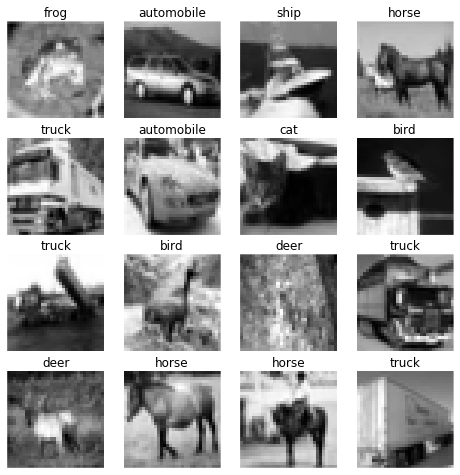

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
figs, axes = plt.subplots(4, 4, figsize=(8, 8))
for i in range(4):
    for j in range(4):
        axes[i, j].imshow(cifar10.train.images[i + 4 * j][:32*32].reshape(32, 32), cmap='gray', interpolation='none')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].set_title("{}".format( cifar10.names[np.argmax(cifar10.train.labels[i + 4 * j])] ))
        axes[i, j].axis('off')

### Implementing Convolutional Nural Networks

#### utilities

In [3]:
import re
def _activation_summary(x):
    """Helper to create summaries for activations.
    Creates a summary that provides a histogram of activations.
    Creates a summary that measure the sparsity of activations.
    Args:
        x: Tensor
    Returns:
        nothing
    """
    # Remove 'tower_[0-9]/' from the name in case this is a multi-GPU training
    # session. This helps the clarity of presentation on tensorboard.
    tensor_name = re.sub('%s_[0-9]*/' % 'tower', '', x.op.name)
    tf.histogram_summary(tensor_name + '/activations', x)
    tf.scalar_summary(tensor_name + '/sparsity', tf.nn.zero_fraction(x))

#### Network (inference)

In [4]:
import numpy as np

def inference(images):
    with tf.variable_scope('conv1') as scope:
        reshaped = tf.reshape(images, [-1, 32, 32, 3])
        
        weights = tf.get_variable('weight', [5, 5, 3, 64], initializer=tf.truncated_normal_initializer(stddev=1e-4))
        biases = tf.get_variable('biases', [64], initializer=tf.constant_initializer(0.1))
        
        _ = tf.nn.bias_add( tf.nn.conv2d(reshaped, weights, [1, 1, 1, 1], padding='SAME'), biases )
        conv1 = tf.nn.relu(_, name=scope.name)
        _activation_summary(conv1)
        
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool1')
    norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')
    
    with tf.variable_scope('conv2') as scope:
        weights = tf.get_variable('weight', [5, 5, 64, 64], initializer=tf.truncated_normal_initializer(stddev=1e-4))
        biases = tf.get_variable('biases', [64], initializer=tf.constant_initializer(0.1))
        
        _ = tf.nn.bias_add( tf.nn.conv2d(norm1, weights, [1, 1, 1, 1], padding='SAME'), biases )
        conv2 = tf.nn.relu(_, name=scope.name)
        _activation_summary(conv2)
        
    norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')
    pool2 = tf.nn.max_pool(norm2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool2')

    with tf.variable_scope('local3') as scope:
        dim = reduce(lambda x, y: x*y, pool2.get_shape()[1:].as_list())
        reshaped = tf.reshape(pool2, [-1, dim])
        
        weights = tf.get_variable('weight', [dim, 384], initializer=tf.truncated_normal_initializer(stddev=0.04))
        biases = tf.get_variable('biases', [384], initializer=tf.constant_initializer(0.1))
        
        local3 = tf.nn.relu_layer(reshaped, weights, biases, name=scope.name)
        _activation_summary(local3)
    
    with tf.variable_scope('local4') as scope:
        weights = tf.get_variable('weight', [384, 192], initializer=tf.truncated_normal_initializer(stddev=0.04))
        biases = tf.get_variable('biases', [192], initializer=tf.constant_initializer(0.1))
        
        local4 = tf.nn.relu_layer(local3, weights, biases, name=scope.name)
        _activation_summary(local4)
        
    with tf.variable_scope('softmax_linear') as scope:
        weights = tf.get_variable('weight', [192, 10], initializer=tf.truncated_normal_initializer(stddev=0.005))
        biases = tf.get_variable('biases', [10], initializer=tf.constant_initializer(0.1))
        
        softmax_linear = tf.nn.xw_plus_b(local4, weights, biases, name=scope.name)
        _activation_summary(softmax_linear)
        
    return softmax_linear


In [5]:
# without decay
def loss(logits, labels):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, labels, name='cross_entropy_per_example')
    cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
    
    return cross_entropy_mean

#### train

In [ ]:
MINIBATCH = 128

import time
from datetime import datetime
import tensorflow as tf
def train():
    with tf.Graph().as_default():
        images = tf.placeholder(tf.float32, [None, cifar10.input_size])
        labels = tf.placeholder(tf.float32, [None, cifar10.num_classes])

        logits = inference(images)
        total_loss = loss(logits, labels)
        
        opt = tf.train.AdamOptimizer()
        grads = opt.compute_gradients(total_loss)
        
        apply_gradient_op = opt.apply_gradients(grads)
        
        for var in tf.trainable_variables():
            tf.histogram_summary(var.op.name, var)
        for grad,var in grads:
            if grad:
                tf.histogram_summary(var.op.name+'/gradients', grad)
                
        with tf.control_dependencies([apply_gradient_op]):
            train_op = tf.no_op(name='train')
            
        summary_op = tf.merge_all_summaries()
        
        # Start running operations on the Graph.
        sess= tf.Session()
        with tf.device('/gpu:0'):
            init = tf.initialize_all_variables()
            sess.run(init)
        
            summary_writer = tf.train.SummaryWriter('tmp/cifar10_train', graph_def=sess.graph_def)
        
            for step in xrange(1001):
                start_time = time.time()
                batch = cifar10.train.next_batch(MINIBATCH)
            
                _, loss_value = sess.run([train_op, total_loss], feed_dict={images: batch[0], labels: batch[1]})
            
                duration = time.time() - start_time
            
            
                if step % 10 == 0:
                    num_examples_per_step = MINIBATCH
                    examples_per_sec = num_examples_per_step / duration
                    sec_per_batch = float(duration)
                
                    format_str = ('%s: epoch %04d, step %04d, loss = %.2f (%.1f examples/sec; %.3f sec/batch)')
                    print (format_str % (datetime.now(), cifar10.train.epochs_completed, step, loss_value, examples_per_sec, sec_per_batch))
                    
                if step % 100 == 0:
                    summary_str = sess.run(summary_op, feed_dict={images: batch[0], labels: batch[1]})
                    summary_writer.add_summary(summary_str, step)
                    


In [ ]:
train()

2016-01-06 18:44:38.278544: epoch 0000, step 0000, loss = 2.30 (344.7 examples/sec; 0.371 sec/batch)
2016-01-06 18:44:40.251478: epoch 0000, step 0010, loss = 2.30 (855.3 examples/sec; 0.150 sec/batch)
2016-01-06 18:44:41.830521: epoch 0000, step 0020, loss = 2.30 (791.1 examples/sec; 0.162 sec/batch)
2016-01-06 18:44:43.424261: epoch 0000, step 0030, loss = 2.31 (778.1 examples/sec; 0.165 sec/batch)
2016-01-06 18:44:45.005652: epoch 0000, step 0040, loss = 2.24 (809.4 examples/sec; 0.158 sec/batch)
2016-01-06 18:44:46.592752: epoch 0000, step 0050, loss = 2.20 (789.1 examples/sec; 0.162 sec/batch)
2016-01-06 18:44:48.164995: epoch 0000, step 0060, loss = 2.13 (798.7 examples/sec; 0.160 sec/batch)
2016-01-06 18:44:49.746354: epoch 0000, step 0070, loss = 2.16 (809.9 examples/sec; 0.158 sec/batch)
2016-01-06 18:44:51.329754: epoch 0000, step 0080, loss = 2.13 (826.6 examples/sec; 0.155 sec/batch)
2016-01-06 18:44:52.924972: epoch 0000, step 0090, loss = 2.07 (839.8 examples/sec; 0.152 s